In [1]:
import os
import random
import glob
import numpy as np
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.wcs.utils import skycoord_to_pixel
import warnings
import time
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import numba as nb
from numba import float64, int64, float32, int32
from astropy import units as u

In [2]:
file_path = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.246.289.r/'
fits_file_r = 'CFIS_LSB.246.289.r.fits'
file = os.path.join(file_path,fits_file_r)

with fits.open(file, memmap=True) as hdul:
    data = hdul[0].data

In [143]:
#@nb.njit()
def cutout2d(data_, x, y, size, cutout_in):
        
    y_large, x_large = data_.shape
    # y, x = position
    height, width = size, size
    x, y = round(x), round(y)

    y_start = max(0, y - height // 2)
    y_end = min(y_large, y + (height + 1) // 2)

    x_start = max(0, x - width // 2)
    x_end = min(x_large, x + (width + 1) // 2)

    if y_start >= y_end or x_start >= x_end:
        raise ValueError("No overlap between the small and large array.")

    # cutout = np.zeros((size, size), dtype=data.dtype)
    cutout_in[y_start - y + height // 2 : y_end - y + height // 2, x_start - x + width // 2 : x_end - x + width // 2] = \
        data_[y_start:y_end, x_start:x_end]

    return cutout_in

In [145]:
n = 10**4
x, y = 6234.256, 2525.642
x, y = 0.1, 2525.1
size = 224
data_in = data.astype(np.float32)
cutout_empty = np.zeros((size, size), dtype=np.float32)
cutout_stackd = np.zeros((n, size, size))
start = time.time()
for i in range(10**4):
    # x, y = int(np.floor(xs[i] + 0.5)), int(np.floor(ys[i] + 0.5))
    cutout_stackd[i] = cutout2d(data_in, x, y, size, cutout_empty)
print(f'Execution time: {time.time()-start} seconds.')

Execution time: 0.9390866756439209 seconds.


In [146]:
start = time.time()
cutout_stackD = np.zeros((n, size, size))
for i in range(10**4):
    # x, y = int(np.floor(xs[i] + 0.5)), int(np.floor(ys[i] + 0.5))
    cutout_stackD[i] = Cutout2D(data, (x, y), size, mode='partial', fill_value=0).data
print(f'Execution time: {time.time()-start} seconds.')

Execution time: 1.6261522769927979 seconds.


In [166]:
np.array_equal(cutout_stackD[0], cutout_stackd[0])

False

In [198]:
import pandas as pd

data1 = {'ID': [1, 2, 3, 4],
         'label': ['A', 'B', np.nan, 'D']}
data2 = {'ID': [5, 6, 7, 8],
         'label': ['B', 'D', np.nan, np.nan]}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Choose the column for comparison
column_to_compare = 'label'

# Count the number of matching rows in the specified column
num_matching_rows = (df1[column_to_compare].fillna('nan') == df2[column_to_compare].fillna('nan'))


In [199]:
num_matching_rows

0    False
1    False
2     True
3    False
Name: label, dtype: bool

In [190]:
df2

,ID,label
0,5,B
1,6,D
2,7,NaN
3,8,NaN


In [182]:
cutout_stackD[0][111,111]

0.299708753824234

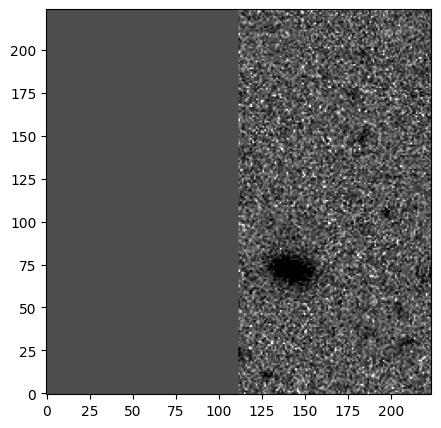

In [147]:
plot_cutout = cutout_stackd[0]
plt.close('all')
fig = plt.figure(figsize=(5, 5))
norm = simple_norm(plot_cutout, 'sqrt', percent=98.5)
ax = plt.subplot()
ax.imshow(plot_cutout, norm=norm, cmap='gray_r', origin='lower')
plt.show()